In [2]:
from polygraphs.analysis import Processor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest

import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

/Users/prudhvivuda/Documents/polygraphs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
processor = Processor(["../../../CollegeMSG/"], config_check=False)
processor.add_config("reliability")

In [4]:
# Collect Belief Data
beliefs = pd.DataFrame()

for sim in processor.sims.iterrows():
    _ = processor.beliefs[sim[0]].copy()
    _["sim"] = sim[0]
    _["op"] = sim[1].op
    _["reliability"] = sim[1].reliability
    beliefs = pd.concat([beliefs, _])

blfs = beliefs.copy()

In [27]:
# Aggregate Beliefs at Graph Level 
aggregated_beliefs = (
    beliefs.groupby(["op", "iteration"])
    .agg(
        mean_beliefs=("beliefs", "mean"),
        median_beliefs=("beliefs", "median"),
        std_beliefs=("beliefs", "std"),
        min_beliefs=("beliefs", "min"),
        max_beliefs=("beliefs", "max"),
        p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
        p75_beliefs=("beliefs", lambda x: x.quantile(0.75))
    )
    .reset_index()
)

In [29]:
aggregated_beliefs

,op,iteration,mean_beliefs,median_beliefs,std_beliefs,min_beliefs,max_beliefs,p25_beliefs,p75_beliefs
0,BalaGoyalOp,0,0.499408,0.499355,0.288425,0.000006,0.999983,0.249112,0.74951
1,BalaGoyalOp,1,0.500695,0.50094,0.290212,0.000008,0.999982,0.247771,0.754314
2,BalaGoyalOp,100,0.549492,0.577514,0.334699,0.0,1.0,0.240645,0.873266
3,BalaGoyalOp,200,0.584292,0.641665,0.346922,0.0,1.0,0.262126,0.929545
4,BalaGoyalOp,300,0.613346,0.699643,0.352041,0.0,1.0,0.289662,0.963901
...,...,...,...,...,...,...,...,...,...
1507,UnreliableNetworkModifiedAlignedNegativeEpsOp,24600,0.795627,0.999981,0.352806,0.0,1.0,0.743797,1.0
1508,UnreliableNetworkModifiedAlignedNegativeEpsOp,24700,0.795372,0.999982,0.352971,0.0,1.0,0.744057,1.0
1509,UnreliableNetworkModifiedAlignedNegativeEpsOp,24800,0.797065,0.999983,0.35166,0.0,1.0,0.751271,1.0
1510,UnreliableNetworkModifiedAlignedNegativeEpsOp,24900,0.798718,0.999984,0.350696,0.0,1.0,0.76042,1.0


## ANOVA Test

#### Hypotheses

- Null Hypothesis: \( H_0 \): There is no significant difference in mean credence across operators.
- Alternative Hypothesis: \( H_a \): There is a significant difference in mean credence across operators.

In [30]:
# Group data by 'op' and collect mean beliefs
grouped = aggregated_beliefs.groupby('op')['mean_beliefs'].apply(list).reset_index()

# Perform ANOVA test
anova_result = stats.f_oneway(*grouped['mean_beliefs'])
print(f"ANOVA Test: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")

ANOVA Test: F-statistic = 236.8847198486328, p-value = 0.0


Reject the null hypothesis.

## Tukey's HSD Test

Let's compare all pairs of groups to find where the differences lie.

                                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                                       
                   group1                                       group2                    meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------------------------------
                                BalaGoyalOp      UnreliableNetworkBasicGullibleBinomialOp  -0.0451    0.0 -0.0652 -0.0249   True
                                BalaGoyalOp   UnreliableNetworkBasicGullibleNegativeEpsOp  -0.1534    0.0 -0.1735 -0.1333   True
                                BalaGoyalOp                      UnreliableNetworkIdealOp  -0.0316 0.0001 -0.0517 -0.0115   True
                                BalaGoyalOp    UnreliableNetworkModifiedAlignedBinomialOp  -0.0863    0.0 -0.1065 -0.0662   True
                                BalaGoyalOp UnreliableNetworkModifiedAlignedNegativeEpsOp  -0.199

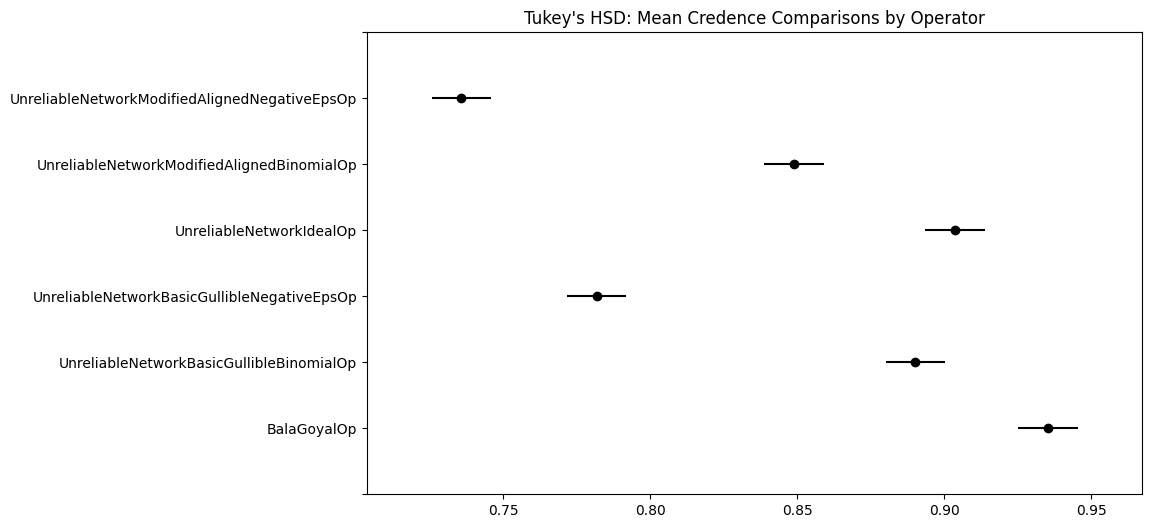

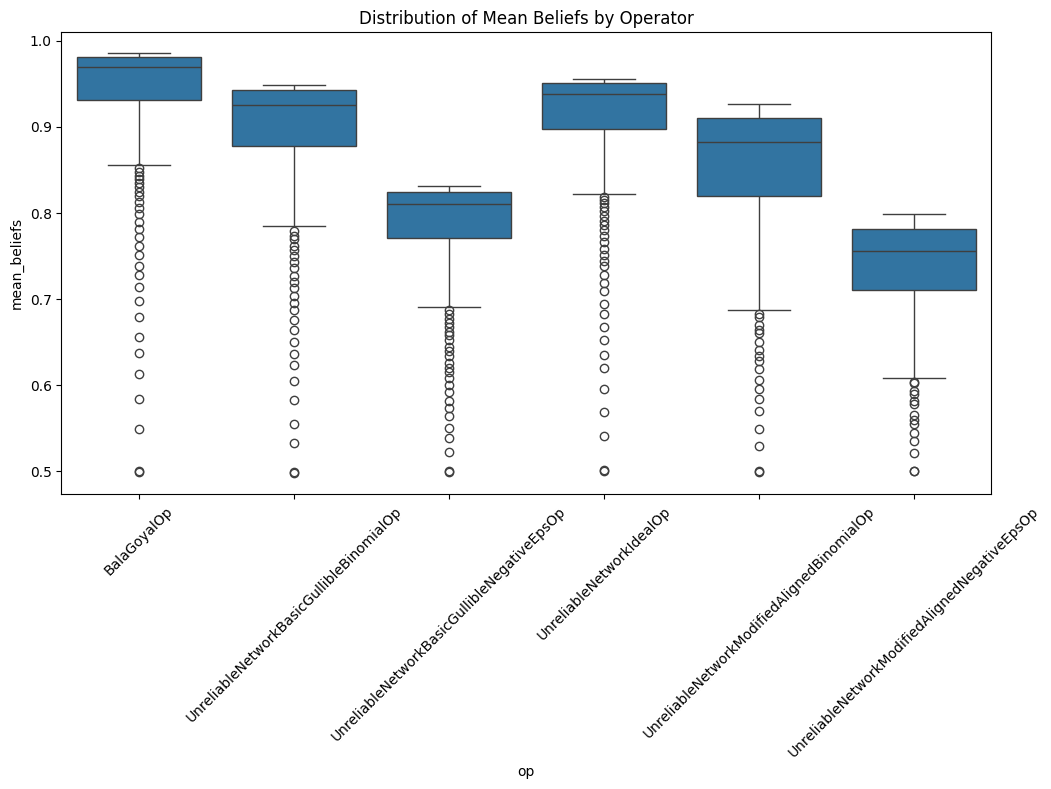

In [31]:
# Tukey's HSD Test
tukey_data = aggregated_beliefs[['op', 'mean_beliefs']].dropna()

tukey = pairwise_tukeyhsd(
    endog=tukey_data['mean_beliefs'],
    groups=tukey_data['op'],
    alpha=0.05
)

print(tukey)

# Visualize Pairwise Comparisons
fig = tukey.plot_simultaneous()
plt.title("Tukey's HSD: Mean Credence Comparisons by Operator")
plt.show()

# Boxplot Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(x='op', y='mean_beliefs', data=aggregated_beliefs)
plt.title('Distribution of Mean Beliefs by Operator')
plt.xticks(rotation=45)
plt.show()


## Kolmogorov-Smirnov Test

Pairwise comparisons of distributions for each op.

In [32]:
# Pairwise KS Test
print("\nKolmogorov-Smirnov Test Results:")
for i, op1 in enumerate(grouped['op']):
    for j, op2 in enumerate(grouped['op']):
        if i < j:
            ks_stat, p_value = kstest(grouped.loc[i, 'mean_beliefs'], grouped.loc[j, 'mean_beliefs'])
            print(f"{op1} vs {op2}: KS-statistic = {ks_stat}, p-value = {p_value}")


Kolmogorov-Smirnov Test Results:
BalaGoyalOp vs UnreliableNetworkBasicGullibleBinomialOp: KS-statistic = 0.6706349206349206, p-value = 4.267211929646723e-54
BalaGoyalOp vs UnreliableNetworkBasicGullibleNegativeEpsOp: KS-statistic = 0.9087301587301587, p-value = 3.576705877433012e-111
BalaGoyalOp vs UnreliableNetworkIdealOp: KS-statistic = 0.6349206349206349, p-value = 5.159806972040643e-48
BalaGoyalOp vs UnreliableNetworkModifiedAlignedBinomialOp: KS-statistic = 0.7619047619047619, p-value = 4.656126435575067e-72
BalaGoyalOp vs UnreliableNetworkModifiedAlignedNegativeEpsOp: KS-statistic = 0.9285714285714286, p-value = 5.437748259444372e-118
UnreliableNetworkBasicGullibleBinomialOp vs UnreliableNetworkBasicGullibleNegativeEpsOp: KS-statistic = 0.8452380952380952, p-value = 2.8918980891719627e-92
UnreliableNetworkBasicGullibleBinomialOp vs UnreliableNetworkIdealOp: KS-statistic = 0.30952380952380953, p-value = 4.608628503526758e-11
UnreliableNetworkBasicGullibleBinomialOp vs UnreliableN

## Data grouped by Iteration groups

In [21]:
if 'iteration' not in blfs.columns:
    if isinstance(blfs.index, pd.MultiIndex):
        # Extract 'iteration' from MultiIndex if available
        blfs = blfs.reset_index()
    else:
        # Create a synthetic 'iteration' based on row indices
        blfs['iteration'] = blfs.index

# Adding a new column for iteration groups (e.g., 0-4999, 5000-9999, etc.)
blfs['iteration_group'] = (blfs['iteration'] // 5000) * 5000

In [22]:
# Aggregate beliefs at the graph level, considering iteration groups
aggregated_beliefs = (
    blfs.groupby(["op", "iteration_group"])
    .agg(
        mean_beliefs=("beliefs", "mean"),
        median_beliefs=("beliefs", "median"),
        std_beliefs=("beliefs", "std"),
        min_beliefs=("beliefs", "min"),
        max_beliefs=("beliefs", "max"),
        p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
        p75_beliefs=("beliefs", lambda x: x.quantile(0.75))
    )
    .reset_index()
)

# Group data by 'op' and collect mean beliefs for Tukey's HSD and ANOVA
grouped = aggregated_beliefs.groupby('op')['mean_beliefs'].apply(list).reset_index()


In [23]:
# Perform ANOVA test
anova_result = stats.f_oneway(*grouped['mean_beliefs'])
print(f"ANOVA Test: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")

ANOVA Test: F-statistic = 6.720494747161865, p-value = 0.00026141959824599326


In [24]:
# Tukey's HSD Test
tukey_data = aggregated_beliefs[['op', 'mean_beliefs']].dropna()

tukey = pairwise_tukeyhsd(
    endog=tukey_data['mean_beliefs'],
    groups=tukey_data['op'],
    alpha=0.05
)

print(tukey)

                                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                                       
                   group1                                       group2                    meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------------------------------
                                BalaGoyalOp      UnreliableNetworkBasicGullibleBinomialOp  -0.0437 0.8978 -0.1705  0.0831  False
                                BalaGoyalOp   UnreliableNetworkBasicGullibleNegativeEpsOp  -0.1537 0.0105 -0.2806 -0.0269   True
                                BalaGoyalOp                      UnreliableNetworkIdealOp  -0.0314 0.9733 -0.1582  0.0955  False
                                BalaGoyalOp    UnreliableNetworkModifiedAlignedBinomialOp  -0.0827 0.3754 -0.2095  0.0442  False
                                BalaGoyalOp UnreliableNetworkModifiedAlignedNegativeEpsOp  -0.197

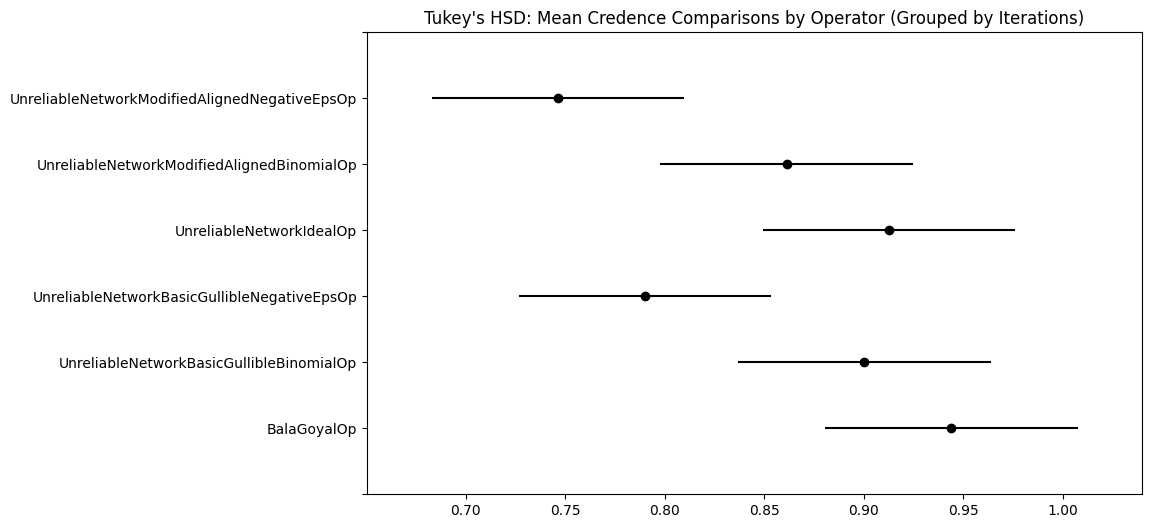

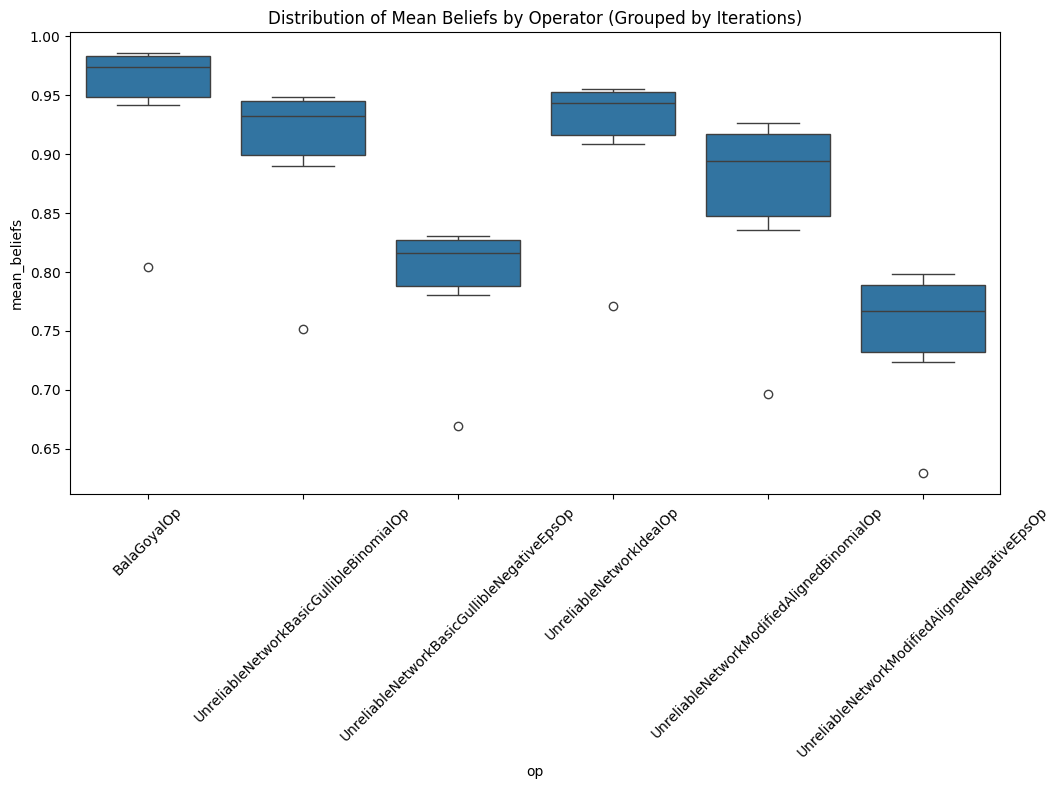

In [25]:
# Visualize Pairwise Comparisons
fig = tukey.plot_simultaneous()
plt.title("Tukey's HSD: Mean Credence Comparisons by Operator (Grouped by Iterations)")
plt.show()

# Boxplot Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(x='op', y='mean_beliefs', data=aggregated_beliefs)
plt.title('Distribution of Mean Beliefs by Operator (Grouped by Iterations)')
plt.xticks(rotation=45)
plt.show()

In [26]:
# Pairwise KS Test
print("\nKolmogorov-Smirnov Test Results:")
for i, op1 in enumerate(grouped['op']):
    for j, op2 in enumerate(grouped['op']):
        if i < j:
            ks_stat, p_value = kstest(grouped.loc[i, 'mean_beliefs'], grouped.loc[j, 'mean_beliefs'])
            print(f"{op1} vs {op2}: KS-statistic = {ks_stat}, p-value = {p_value}")



Kolmogorov-Smirnov Test Results:
BalaGoyalOp vs UnreliableNetworkBasicGullibleBinomialOp: KS-statistic = 0.6666666666666666, p-value = 0.14285714285714285
BalaGoyalOp vs UnreliableNetworkBasicGullibleNegativeEpsOp: KS-statistic = 0.8333333333333334, p-value = 0.025974025974025972
BalaGoyalOp vs UnreliableNetworkIdealOp: KS-statistic = 0.6666666666666666, p-value = 0.14285714285714285
BalaGoyalOp vs UnreliableNetworkModifiedAlignedBinomialOp: KS-statistic = 0.8333333333333334, p-value = 0.025974025974025972
BalaGoyalOp vs UnreliableNetworkModifiedAlignedNegativeEpsOp: KS-statistic = 1.0, p-value = 0.0021645021645021645
UnreliableNetworkBasicGullibleBinomialOp vs UnreliableNetworkBasicGullibleNegativeEpsOp: KS-statistic = 0.8333333333333334, p-value = 0.025974025974025972
UnreliableNetworkBasicGullibleBinomialOp vs UnreliableNetworkIdealOp: KS-statistic = 0.5, p-value = 0.474025974025974
UnreliableNetworkBasicGullibleBinomialOp vs UnreliableNetworkModifiedAlignedBinomialOp: KS-statistic

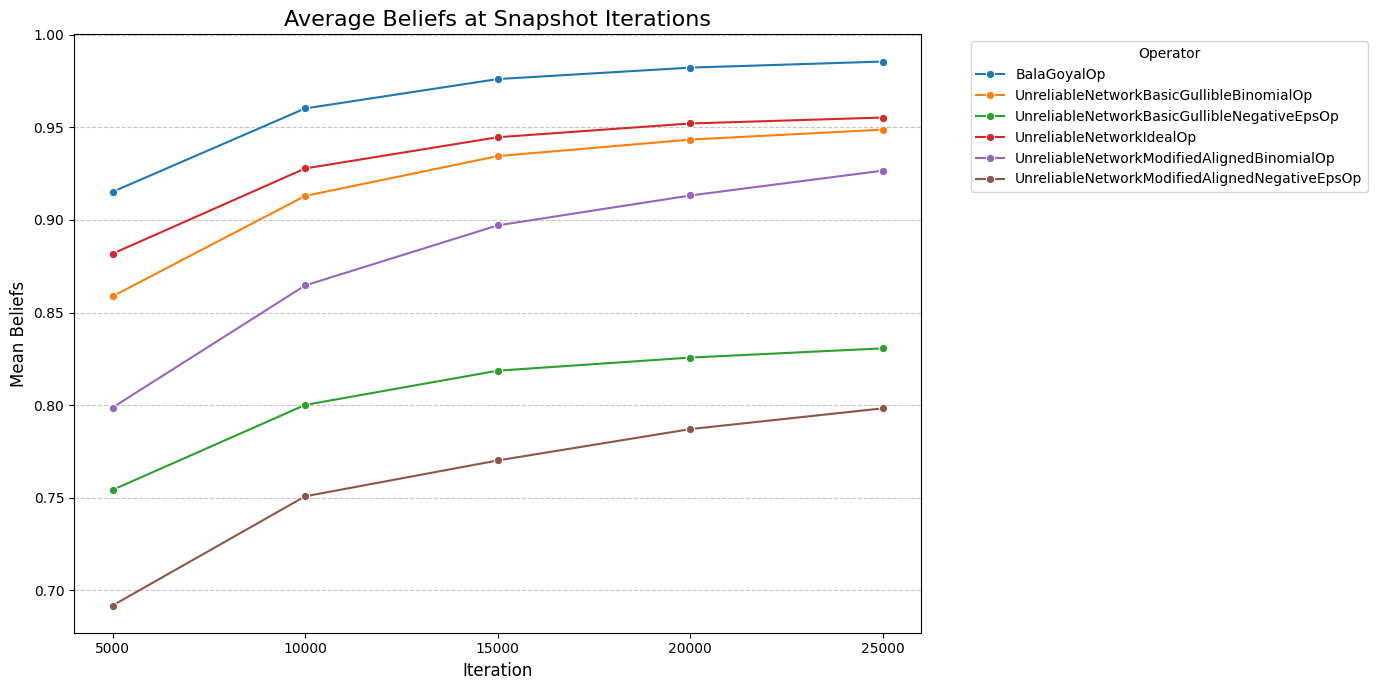

 INFO matplotlib.category> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
 INFO matplotlib.category> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


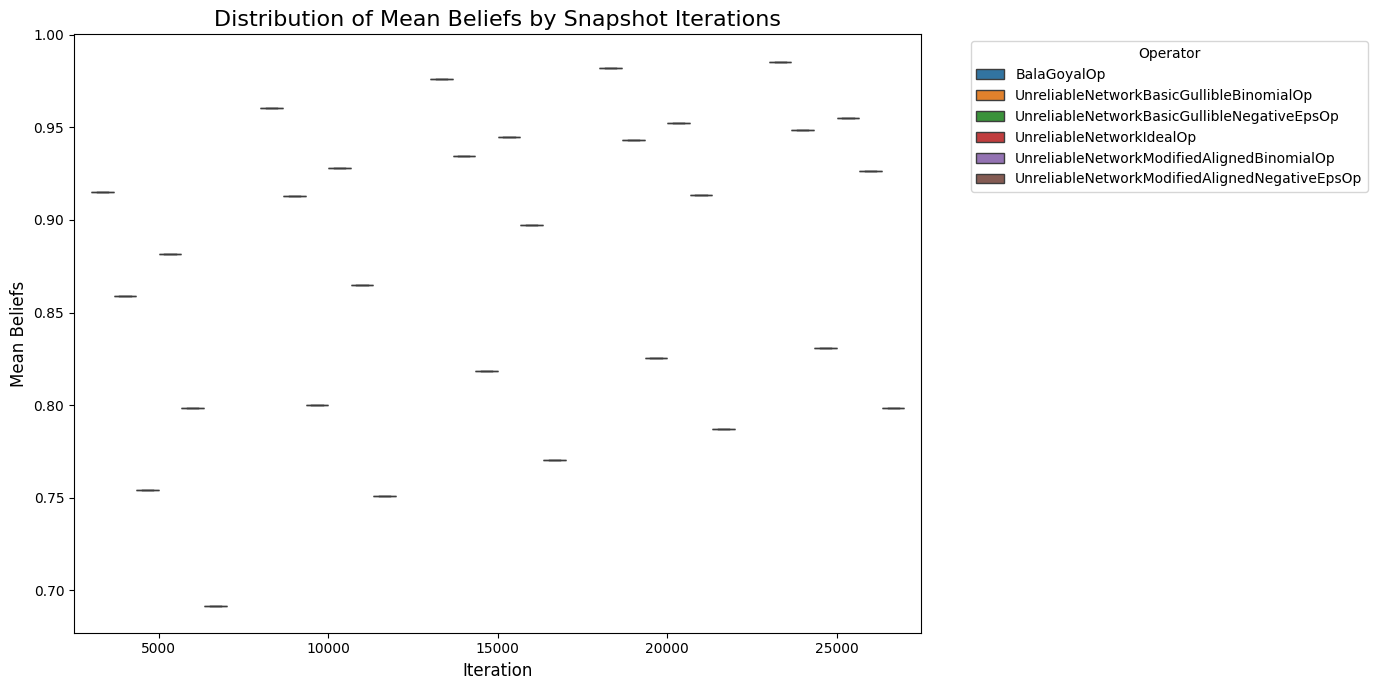

In [7]:
# Ensure 'iteration' is in columns
if 'iteration' not in blfs.columns:
    if isinstance(blfs.index, pd.MultiIndex):
        # Extract 'iteration' from MultiIndex if available
        blfs = blfs.reset_index()
    else:
        # Create a synthetic 'iteration' based on row indices
        blfs['iteration'] = blfs.index

# Specify snapshot iterations
snapshot_iterations = [5000, 10000, 15000, 20000, 25000]

# Filter beliefs for the specific snapshot iterations
filtered_beliefs = blfs[blfs['iteration'].isin(snapshot_iterations)]

# Aggregate beliefs at graph level for these iterations
snapshot_aggregated = (
    filtered_beliefs.groupby(["op", "iteration"])
    .agg(
        mean_beliefs=("beliefs", "mean"),
        median_beliefs=("beliefs", "median"),
        std_beliefs=("beliefs", "std"),
        min_beliefs=("beliefs", "min"),
        max_beliefs=("beliefs", "max"),
        p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
        p75_beliefs=("beliefs", lambda x: x.quantile(0.75))
    )
    .reset_index()
)

# Visualize average beliefs at each snapshot iteration
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=snapshot_aggregated,
    x="iteration",
    y="mean_beliefs",
    hue="op",
    marker="o",
    palette="tab10"
)
plt.title("Average Beliefs at Snapshot Iterations", fontsize=16)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Mean Beliefs", fontsize=12)
plt.xticks(snapshot_iterations)  # Ensure iterations align
plt.legend(title="Operator", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Boxplot of mean beliefs at each snapshot iteration by operator
plt.figure(figsize=(14, 7))
sns.boxplot(
    data=snapshot_aggregated,
    x="iteration",
    y="mean_beliefs",
    hue="op",
    palette="tab10"
)
plt.title("Distribution of Mean Beliefs by Snapshot Iterations", fontsize=16)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Mean Beliefs", fontsize=12)
plt.legend(title="Operator", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.savefig("images/average_beliefs_snapshots.png", format="png", dpi=300, bbox_inches="tight")
plt.savefig("images/average_beliefs_snapshots.svg", format="svg", bbox_inches="tight")

plt.show()
